Exploring the output files generated by the Salish Sea Atlantis Model
for the BC Parks Living Labs Project - preliminary runs

Scenarios
- control
- heatwave (2023 summer for 10 days)
- climate change (+2oC warming by 2050)

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [2]:

species_of_interest = { #benthic, 1 depth
    'macroalgae':'Macroalgae', 'seagrass':'Seagrass', 'bivalves':'Bivalves',
}
boxes = [63, 66, 83, 96, 102]
locations = { 
   63:'Trincomali Channel', 66:'Saanich Inlet', 83: 'Sunshine Coast', 96: 'Hornby & Denman Islands', 102: 'Cape Lazo',
}

In [3]:
label_size = 11
font_size = 12
line_width = 2

## scenario files

In [4]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/control_01/outputSalishSea.nc"
heatwave_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/heatwave_01/outputSalishSea.nc"
climate_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/climate_04/outputSalishSea.nc"

control = xr.open_dataset(str(control_file), decode_cf=True)
heatwave = xr.open_dataset(str(heatwave_file), decode_cf=True)
climate = xr.open_dataset(str(climate_file), decode_cf=True)

t = np.ma.filled(control.variables['t'], np.nan)

In [5]:
t[0]

numpy.datetime64('2021-12-27T14:00:00.000000000')

In [6]:
#If different time scale neeeded
start = 0
end = 118 #t.size-1

time = t[start:end]

In [7]:
time[end-1]

numpy.datetime64('2050-10-26T14:00:00.000000000')

In [8]:
# Masking based on temperature

Temps = np.ma.filled(control.Temp[1,:,5], np.nonzero)
(ocean_boxes) = Temps.nonzero()
ocean_boxes = ocean_boxes[0]
ocean_boxes = ocean_boxes[1:ocean_boxes.size-1]
ocean_boxes

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
        15,  16,  18,  19,  20,  21,  23,  26,  28,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  54,  55,  57,  58,  60,  62,  63,
        64,  66,  68,  72,  73,  74,  75,  79,  80,  81,  82,  83,  84,
        85,  86,  88,  90,  91,  92,  94,  96,  98, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124])

## climate change

In [9]:
def plot_benthic_box(group, scenario, locations): # benthos, shellfish

    for box_number in locations:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('Percent (%) change relatuve to control')
        ax.set_title(locations[box_number], fontsize = font_size)
        # ax.set_ylim(y_min, y_max)

        for species in group:
            benthic_oiled = scenario.variables[group[species] + '_N'][start:end,box_number] # tonnes
            benthic_control = control.variables[group[species] + '_N'][start:end,box_number]
            ratio = (benthic_oiled / benthic_control-1)*100
            control_ratio = (benthic_control / benthic_control-1)*100
            ax.plot(time, ratio ,'.')
            #np.savetxt(group[species]+'_'+locations[box_number]+'.csv', ratio, delimiter=",")
        
        ax.legend(group, loc='best')
        ax.plot(time, control_ratio, 'k', linewidth = 2)
        ax.set_xlim([t[0], t[end-1]])
        ax.xaxis.set_minor_locator(MultipleLocator(365.2425)) 

In [10]:
def plot_benthic_average(group, scenario):
  
    boxes = [63, 66, 83, 96, 102]
    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('Percent (%) change relatuve to control')
    # ax.set_ylim(y_min, y_max)

    for species in group:
        benthic_oiled = scenario.variables[group[species] + '_N'][start:end,boxes] # tonnes
        benthic_oiled = benthic_oiled.sum(axis=1)
        benthic_control = control.variables[group[species] + '_N'][start:end,boxes]
        benthic_control = benthic_control.sum(axis=1)

        ratio = (benthic_oiled / benthic_control-1)*100
        control_ratio = (benthic_control / benthic_control-1)*100
        ax.plot(time, ratio ,'.')
        #np.savetxt(group[species]+'_avg.csv', ratio, delimiter=",")

    ax.legend(group, loc='best')
    ax.plot(time, control_ratio, 'k', linewidth = 2)
    ax.set_xlim([t[0], t[end-1]])
    ax.xaxis.set_minor_locator(MultipleLocator(365.2425))   

In [11]:
def plot_benthic_biomass_box(group, scenario, box_number): 

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number], np.nan)
        p_oiled = pelagic_oiled
        p_control = pelagic_control
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)


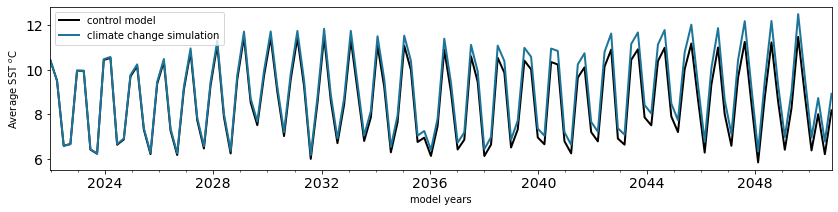

In [12]:
# Temperature at all depths - climate_01
fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=14)

Temp_control = np.ma.filled(control.Temp[start:end,ocean_boxes,5], np.nan)
t_control = Temp_control.mean(axis=1)
#t_control = t_control.mean(axis=1)

Temp_climate = np.ma.filled(climate.Temp[start:end,ocean_boxes,5], np.nan)
t_climate = Temp_climate.mean(axis=1)
#t_climate = t_climate.mean(axis=1)

ax.plot(time, t_control, 'k', linewidth = 2);
ax.plot(time, t_climate, '#1e759a',linewidth = 2);
ax.legend(['control model','climate change simulation'])
ax.set_ylabel('Average SST $^{o}$C');
ax.set_xlabel('model years')
ax.set_xlim([t[0], t[end-1]])
#ax.set_xticks(time);
ax.xaxis.set_minor_locator(MultipleLocator(365.2425))


In [13]:
climate_2050 = t_climate[end-4:end]
control_2050 = t_control[end-4:end]

temp_diff = climate_2050.mean() - control_2050.mean()
print('With Tchange_mult = 1.12, January 2050 is '+ str(temp_diff) + ' degrees above the control (change starts at 2011)')

With Tchange_mult = 1.12, January 2050 is 0.6483623852678573 degrees above the control (change starts at 2011)


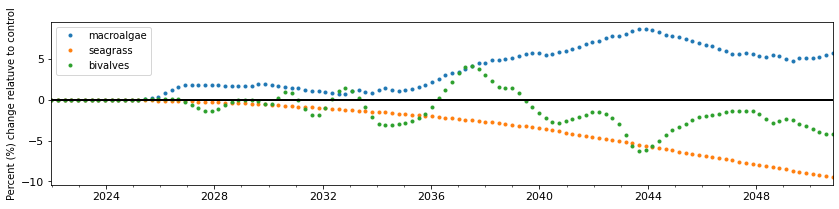

In [14]:
plot_benthic_average(species_of_interest, climate) 

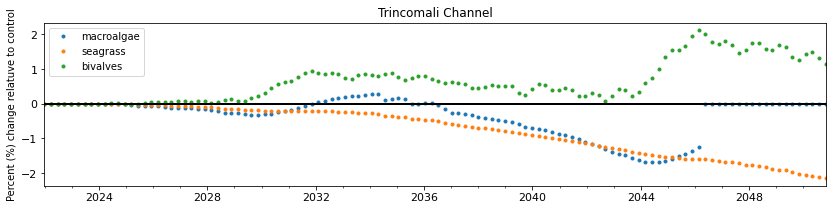

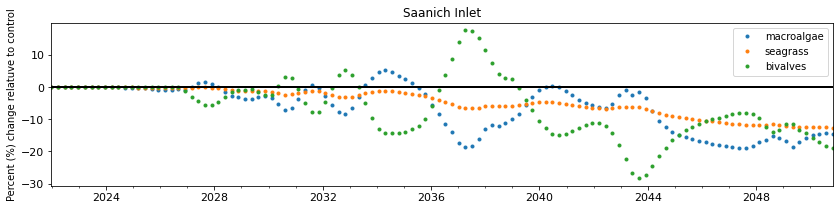

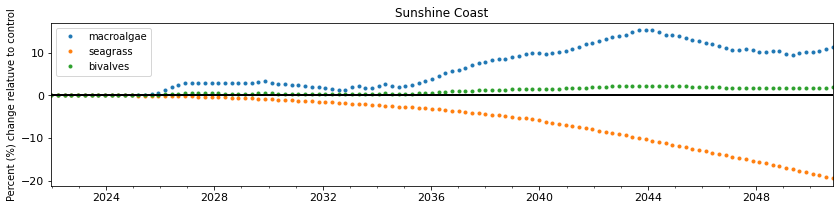

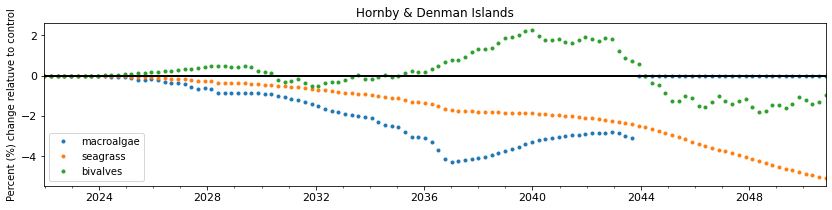

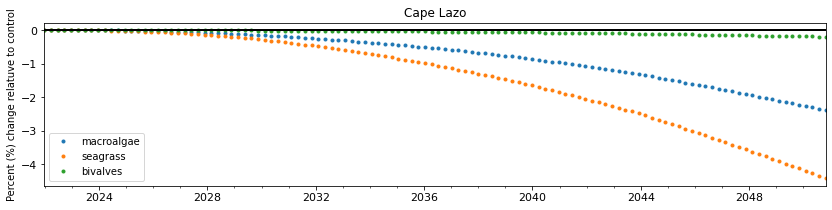

In [15]:
plot_benthic_box(species_of_interest, climate, locations) 

Calculate mean change in biomass for last 5 years of the simulation

In [19]:
df = pd.DataFrame({'Macroalgae': [],
                    'Seagrass': [],
                    'Bivalves': [],})
boxes = [63, 66, 83, 96, 102]
mean_start = end-21
location_index = {}
for box in boxes:
    #scen = climate.variables[species_of_interest[species] + '_N'][mean_start:end,box]
    #cont = control.variables[species_of_interest[species] + '_N'][mean_start:end,box]
    macroalgae1 = np.ma.filled(climate.variables['Macroalgae_N'][mean_start:end,box], np.nan)
    m_control = np.ma.filled(control.variables['Macroalgae_N'][mean_start:end,box], np.nan)
    seagrass1 = np.ma.filled(climate.variables['Seagrass_N'][mean_start:end,box], np.nan)
    s_control = np.ma.filled(control.variables['Seagrass_N'][mean_start:end,box], np.nan)
    bivalves1 = np.ma.filled(climate.variables['Bivalves_N'][mean_start:end,box], np.nan)
    b_control = np.ma.filled(control.variables['Bivalves_N'][mean_start:end,box], np.nan)

    macroalgae = (macroalgae1.mean()/m_control.mean()-1)*100
    seagrass = (seagrass1.mean()/s_control.mean()-1)*100
    bivalves = (bivalves1.mean()/b_control.mean()-1)*100
    location_index[locations[box]] = [locations[box]]

    bio_groups = ['Macroalgae','Seagrass','Bivalves']
    df.loc[len(df.index)] = [macroalgae,seagrass,bivalves]

In [20]:
df

,Macroalgae,Seagrass,Bivalves
0,-0.148941,-1.723054,1.627013
1,-17.450619,-11.239046,-12.304855
2,10.815837,-15.266990,1.765869
3,0.000000,-3.867454,-1.361646
4,-1.946847,-3.565245,-0.160888


In [21]:
location_index

{'Trincomali Channel': ['Trincomali Channel'],
 'Saanich Inlet': ['Saanich Inlet'],
 'Sunshine Coast': ['Sunshine Coast'],
 'Hornby & Denman Islands': ['Hornby & Denman Islands'],
 'Cape Lazo': ['Cape Lazo']}

In [22]:
df.index = location_index

In [23]:
df

,Macroalgae,Seagrass,Bivalves
Trincomali Channel,-0.148941,-1.723054,1.627013
Saanich Inlet,-17.450619,-11.239046,-12.304855
Sunshine Coast,10.815837,-15.266990,1.765869
Hornby & Denman Islands,0.000000,-3.867454,-1.361646
Cape Lazo,-1.946847,-3.565245,-0.160888


In [24]:
time[end-21]

numpy.datetime64('2045-11-21T14:00:00.000000000')

In [36]:
df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/climate_04/radar_averages_with_control.csv")

Radar Plots

In [25]:
def add_to_radar(location_index):
  values = df.loc[location_index].tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=line_width, label=location_index)
  #ax.fill(angles, values, alpha=0.05)

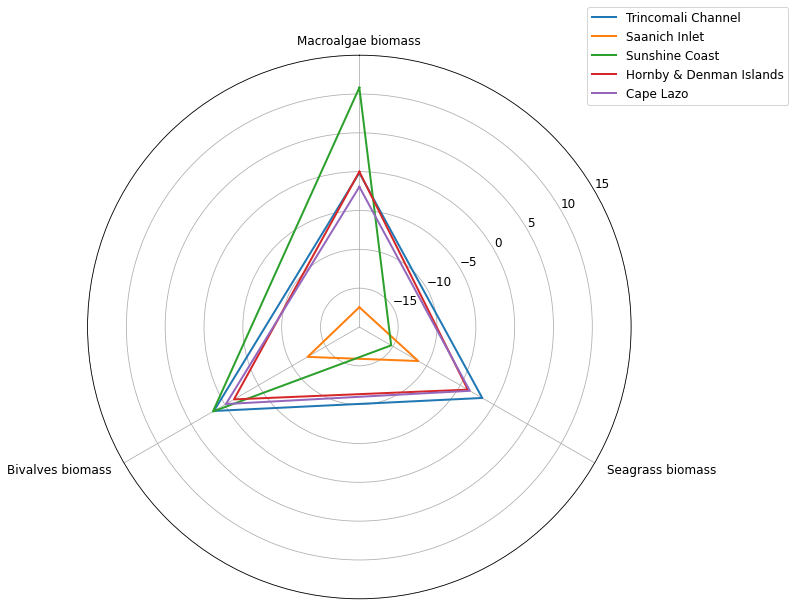

In [67]:
indicators = ['Macroalgae biomass', 'Seagrass biomass', 'Bivalve biomass']
num_vars = len(indicators)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for location in location_index:
    add_to_radar(location)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_ylim(-20, 15)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(indicators)
ax.tick_params(axis='x', labelsize=font_size)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

Adding control line to the plot

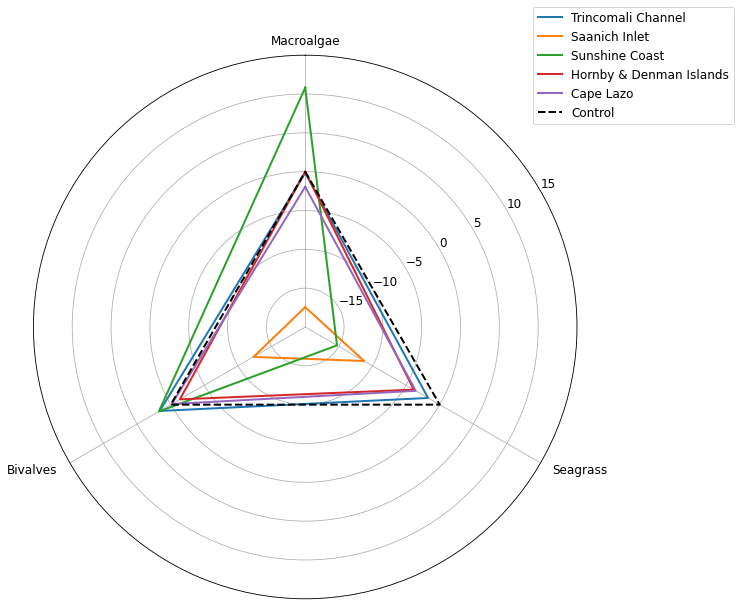

In [36]:
indicators = ['Macroalgae', 'Seagrass', 'Bivalves']
num_vars = len(indicators)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for location in location_index:
    add_to_radar(location)
ax.plot(angles, [0,0,0,0], 'k--',linewidth=line_width, label='Control')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_ylim(-20, 15)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(indicators)
ax.tick_params(axis='x', labelsize=font_size)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

In [27]:
values

NameError: name 'values' is not defined